In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import matplotlib.colors as colors
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
import cartopy.crs as ccrs
%matplotlib inline

In [2]:
ellinkm = 100
fldLoc = '/scratch/srai6/EddyKillingPaper3/CESM/all7yrs_land0/100km_smth/'
ds1 = Dataset(fldLoc + 'tavgFiltered_0100.nc')
ds2 = Dataset(fldLoc + 'tavgNLmodelEP_0100km.nc')

slopeDS = Dataset(fldLoc + 'slopeAndCorr2D_0100km.nc')
slope = np.array(slopeDS.variables['slope'])
corr_coeff2d_fromFile = np.array(slopeDS.variables['corr_coeff'])

gridDS= Dataset(fldLoc + 'tripoleGridCreated.nc')
KMT = np.array(gridDS.variables['KMT'])
UAREA = np.array(gridDS.variables['UAREA'])
ULAT = np.array(gridDS.variables['ULAT'])
ULONG = np.array(gridDS.variables['ULONG'])
#landMask = KMT < 1

gridDS2= Dataset(fldLoc + 'kmtSatToCESM.nc')
satKMT = np.array(gridDS2.variables['KMTsat'])
landMask = np.roll(satKMT > 0,-1800, axis=1)

In [3]:
NLM_tot = np.array(ds2.variables['NLmodel_EPCg'][0,:,:])
NLM2_tot = np.array(ds2.variables['NLmodel2_EPCg'][0,:,:])

NLM_rot = np.array(ds2.variables['NLmodel_EPCg_rot'][0,:,:])
NLM_str = np.array(ds2.variables['NLmodel_EPCg_strain'][0,:,:])

EPPA = np.array(ds1.variables['EddyPowerPerArea'][0,:,:])

landMask = landMask + np.isnan(NLM2_tot)

NLM_tot[landMask] = float('nan')
NLM2_tot[landMask] = float('nan')
NLM_rot[landMask] = float('nan')
NLM_str[landMask] = float('nan')
EPPA[landMask] = float('nan')

In [4]:
dsEPPA_inst = Dataset(fldLoc + '010.nc_0100_Filtered.nc')
dsNLM_inst = Dataset(fldLoc + '010_NLmodelEP_0100km.nc')

iNLM_tot = np.array(dsNLM_inst.variables['NLmodel_EPCg'][0,:,:])
iNLM2_tot = np.array(dsNLM_inst.variables['NLmodel2_EPCg'][0,:,:])

iNLM_rot = np.array(dsNLM_inst.variables['NLmodel_EPCg_rot'][0,:,:])
iNLM_str = np.array(dsNLM_inst.variables['NLmodel_EPCg_strain'][0,:,:])


iEPPA = np.array(dsEPPA_inst.variables['EddyPowerPerArea'][0,:,:])

iNLM_tot[landMask] = float('nan')
iNLM2_tot[landMask] = float('nan')
iNLM_rot[landMask] = float('nan')
iNLM_str[landMask] = float('nan')
iEPPA[landMask] = float('nan')

In [5]:
dsUnfilt_inst = Dataset(fldLoc + '10_smth.nc')
unfilt_UVEL = np.array(dsUnfilt_inst.variables['UGOS'][0,:,:])
unfilt_VVEL = np.array(dsUnfilt_inst.variables['VGOS'][0,:,:])
unfilt_UVEL[landMask] = float('nan')
unfilt_VVEL[landMask] = float('nan')

In [6]:
def streamplotInAxesWithArrows(ax, X, Y, U, V):
    strmlines = ax.streamplot(X, Y, U, V, color='k', density= 4, linewidth=1, arrowstyle = '->',arrowsize = 1)
    #cbar = plt.colorbar(strmlines.lines, ax = ax)

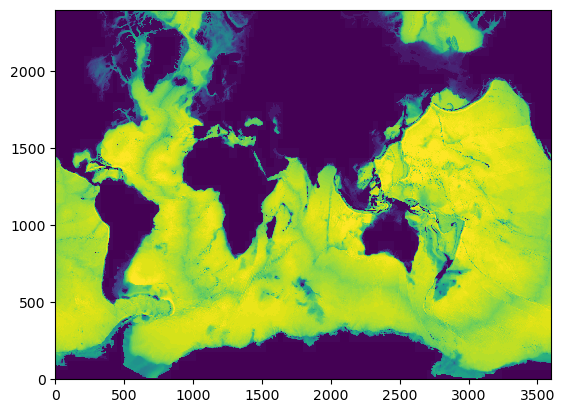

In [7]:
plt.pcolormesh(KMT)

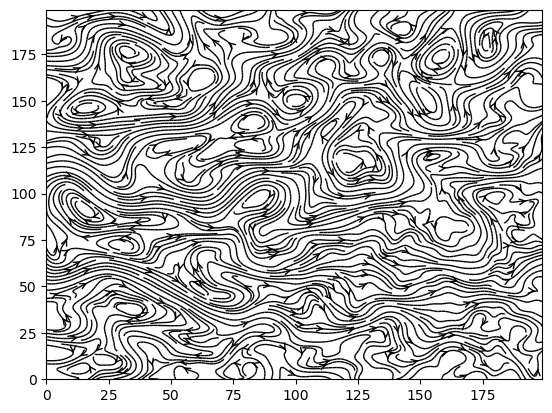

In [8]:
plt.figure()
ax = plt.gca()

y1, y2 = 1500, 1700
x1, x2 = 3000, 3200

X, Y = np.meshgrid(np.arange(200), np.arange(200))
streamplotInAxesWithArrows(ax, X, Y, unfilt_UVEL[y1:y2, x1:x2], unfilt_VVEL[y1:y2, x1:x2])

# streamplotInAxesWithArrows(ax, ULONG[y1:y2, x1:x2], 
#                            ULAT[y1:y2, x1:x2], 
#                            unfilt_UVEL[y1:y2, x1:x2], 
#                            unfilt_UVEL[y1:y2, x1:x2])

In [9]:
def plotStreamOverArr(ax, X, Y, pltArr, U, V, d, cmap, cbTitle, txt, figLabel, 
                      cb=True, 
                      greaterThan = 'True',
                      lessThan = 'True'):
    levels = 150
    level_boundaries = np.linspace(-d, d, levels)
    norm = mpl.colors.BoundaryNorm(level_boundaries, cmap.N)
    
    extd = 'neither'
    if greaterThan and lessThan:
        extd = 'both'
    elif greaterThan:
            extd = 'min'
    elif lessThan:
            extd = 'max'
            
    m = ax.pcolormesh(X-0.5, Y-0.5, pltArr, vmin=-d, vmax=d, cmap=cmap, rasterized=True)
#     m = ax.contourf(X-0.5, Y-0.5, pltArr, levels = level_boundaries, cmap=cmap, norm = norm, extend=extd,
#                             rasterized=True, vmin = -d, vmax = d)
    if cb:
        cbTitle = r'$mWatts/m^2$'
        cb = plt.colorbar(m, ax=ax, extend='both')
        cb.ax.tick_params(labelsize=12)
        cb.ax.set_title(cbTitle, size=12, pad = 20)

    xpos = 0.5
    ypos = 0.85
    fsize = 12

    t = ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy', color ='white' ,
                        verticalalignment='center', transform=ax.transAxes, fontsize=fsize)
    t.set_bbox(dict(facecolor='black', alpha=1, edgecolor=None))

    xpos, ypos = 0.1, 0.85
    t = ax.text(xpos, ypos, figLabel, horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes, 
            fontsize = 12, weight='heavy', color='white')
    t.set_bbox(dict(facecolor='black', alpha=1, edgecolor=None))


    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    streamplotInAxesWithArrows(ax, X, Y, U, V)
    
def plt2d(ax, pltArr, d, cmap, cbTitle, txt, figLabel, cb=True):
    m = ax.pcolormesh(pltArr, vmin=-d, vmax=d, cmap=cmap, rasterized=True)
    if cb:
        cbTitle = r'$mWatts/m^2$'
        cb = plt.colorbar(m, ax=ax, extend='both')
        cb.ax.tick_params(labelsize=12)
        cb.ax.set_title(cbTitle, size=12, pad = 20)


    xpos = 0.5
    ypos = 0.85
    fsize = 12

    ax.text(xpos, ypos, txt, horizontalalignment='center', fontweight = 'heavy',  color ='white' ,
                        verticalalignment='center', transform=ax.transAxes, fontsize=fsize)

    xpos, ypos = 0.1, 0.85
    ax.text(xpos, ypos, figLabel, horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes, 
            fontsize = 12, weight='heavy', color='white')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

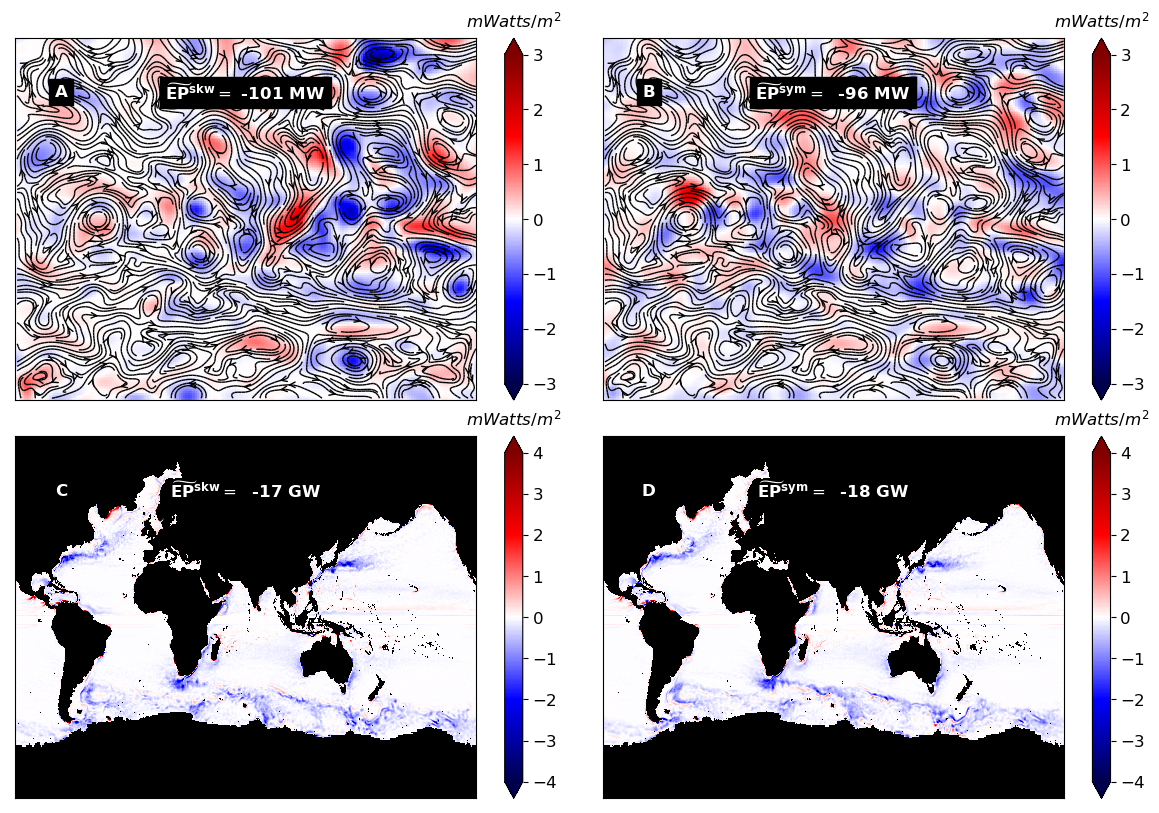

In [10]:
y1, y2 = 1500, 1700
x1, x2 = 3200, 3400
X, Y = np.meshgrid(np.arange(y2-y1), np.arange(x2-x1))

U = unfilt_UVEL[y1:y2, x1:x2].copy()
V = unfilt_VVEL[y1:y2, x1:x2].copy()

ratio = 2.578 #2.729

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')



##########################################################################
d = 3
ax = axes[0,0]
pltArr = iNLM_rot[y1:y2, x1:x2].copy() * ratio
txt = r'$\mathbf{\widetilde{EP}^{skw}} = $' + '{0:5.0f} MW'.format(np.nansum(pltArr*UAREA[y1:y2, x1:x2]*1e-4/1e9))
cbTitle = r'$mWatts/m^2$'
plotStreamOverArr(ax, X, Y, pltArr, U, V, d, cmap, cbTitle, txt, 'A', cb=True)




###########################################################################
d = 3
ax = axes[0,1]
pltArr = iNLM_str[y1:y2, x1:x2].copy() * ratio
txt = r'$\mathbf{\widetilde{EP}^{sym}} = $' + '{0:5.0f} MW'.format(np.nansum(pltArr*UAREA[y1:y2, x1:x2]*1e-4/1e9))
cbTitle = r'$mWatts/m^2$'
plotStreamOverArr(ax, X, Y, pltArr, U, V, d, cmap, cbTitle, txt, 'B', cb=True)



############################### Time Average PLOT #########################
       
d = 4
ax =axes[1,0]

pltArr = NLM_rot.copy() * ratio
txt = r'$\mathbf{\widetilde{EP}^{skw}} = $' + '{0:5.0f} GW'.format(np.nansum(pltArr*UAREA*1e-7/1e9))
plt2d(ax, pltArr, d, cmap, cbTitle, txt, 'C')


#######################################################
ax =axes[1, 1]
pltArr = NLM_str.copy() * ratio
txt1 = r'$\mathbf{\widetilde{EP}^{sym}} = $' + '{0:5.0f} GW'.format(np.nansum(pltArr * UAREA*1e-7/1e9))
#txt2 = '\n r = {0:5.2f}'.format(r_local)
txt = txt1 #+ txt2

plt2d(ax, pltArr, d, cmap, cbTitle, txt, 'D')
plt.subplots_adjust(left=0.01, right=0.98, bottom=0.01, top = 0.96,hspace=0.1, wspace=0.02)
plt.savefig('symAndskwDataCESM.pdf', format='pdf', dpi=70)

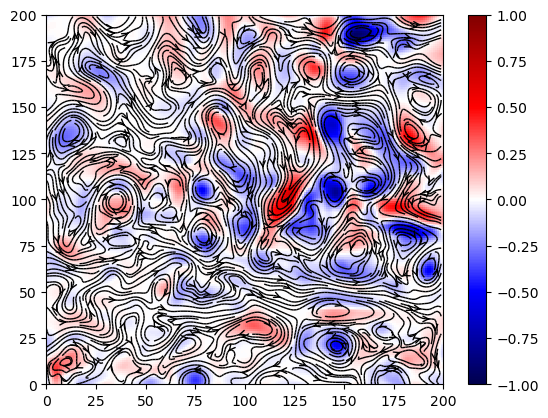

In [11]:
y1, y2 = 1500, 1700
x1, x2 = 3200, 3400

d = 1

ax = plt.gca()

plt.pcolormesh(iNLM_rot[y1:y2,x1:x2],cmap=cmap, vmin=-d, vmax=d)
streamplotInAxesWithArrows(ax, X, Y, unfilt_UVEL[y1:y2, x1:x2], unfilt_VVEL[y1:y2, x1:x2])

plt.colorbar()

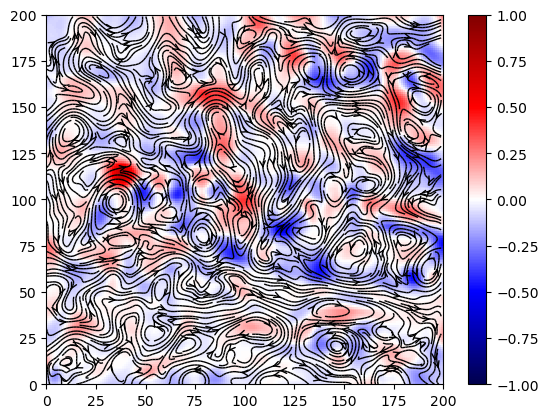

In [12]:
y1, y2 = 1500, 1700
x1, x2 = 3200, 3400

d = 1

ax = plt.gca()

plt.pcolormesh(iNLM_str[y1:y2,x1:x2],cmap=cmap, vmin=-d, vmax=d)
streamplotInAxesWithArrows(ax, X, Y, unfilt_UVEL[y1:y2, x1:x2], unfilt_VVEL[y1:y2, x1:x2])

plt.colorbar()

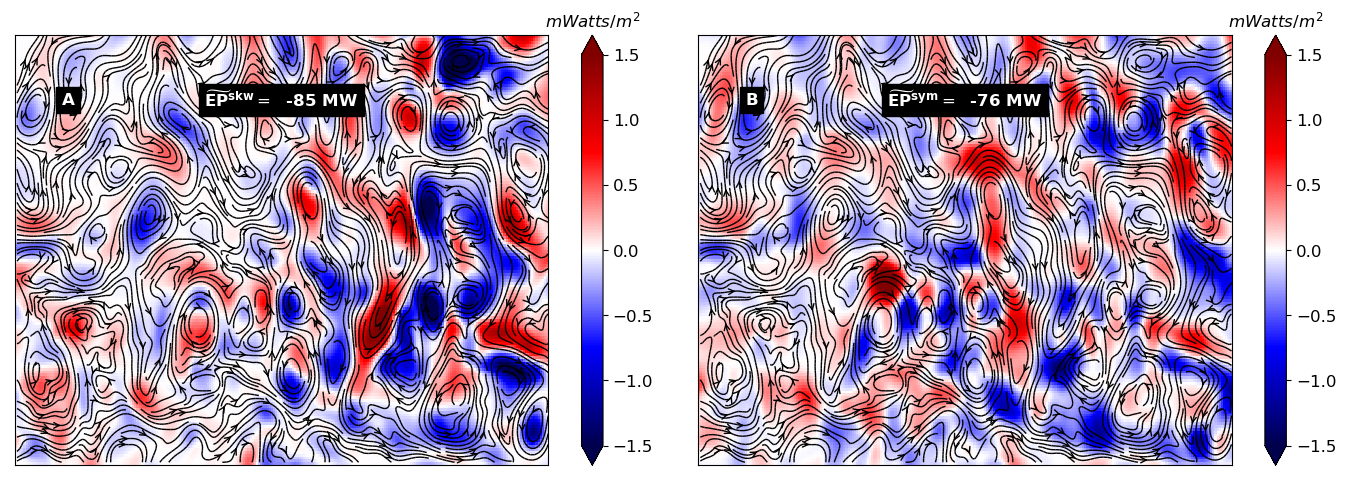

In [13]:
offsetx = -50
offsety = 50

y1, y2 = 1500 + offsety, 1650 + offsety
x1, x2 = 3200 + offsetx, 3450 + offsetx
X = np.arange(x2-x1)
Y = np.arange(y2-y1)
#Y, X = np.meshgrid(np.arange(y2-y1), np.arange(x2-x1))

U = unfilt_UVEL[y1:y2, x1:x2].copy()
V = unfilt_VVEL[y1:y2, x1:x2].copy()

ratio = 2.578 #2.729

fig, axes = plt.subplots(ncols=2, figsize=(15,5))

cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')



##########################################################################
d = 1.5
ax = axes[0]
pltArr = iNLM_rot[y1:y2, x1:x2].copy() * ratio
txt = r'$\mathbf{\widetilde{EP}^{skw}} = $' + '{0:5.0f} MW'.format(np.nansum(pltArr*UAREA[y1:y2, x1:x2]*1e-4/1e9))
cbTitle = r'$mWatts/m^2$'
plotStreamOverArr(ax, X, Y, pltArr, U, V, d, cmap, cbTitle, txt, 'A', cb=True)




###########################################################################
d = 1.5
ax = axes[1]
pltArr = iNLM_str[y1:y2, x1:x2].copy() * ratio
txt = r'$\mathbf{\widetilde{EP}^{sym}} = $' + '{0:5.0f} MW'.format(np.nansum(pltArr*UAREA[y1:y2, x1:x2]*1e-4/1e9))
cbTitle = r'$mWatts/m^2$'
plotStreamOverArr(ax, X, Y, pltArr, U, V, d, cmap, cbTitle, txt, 'B', cb=True)
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.07, top = 0.93, wspace=0.025)
plt.savefig('CESMsymAndskwData_only.pdf', dpi=100)

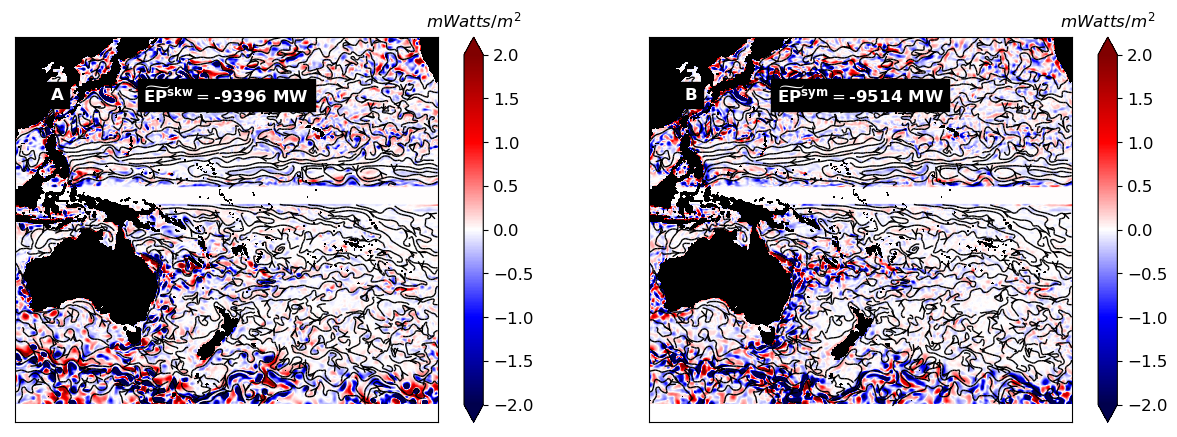

In [14]:
offsetx = -1000
offsety = -1000

y1, y2 = 1500 + offsety, 1700 + offsety + 1000
x1, x2 = 3200 + offsetx, 3500 + offsetx + 1000
X = np.arange(x2-x1)
Y = np.arange(y2-y1)
#Y, X = np.meshgrid(np.arange(y2-y1), np.arange(x2-x1))

U = unfilt_UVEL[y1:y2, x1:x2].copy()
V = unfilt_VVEL[y1:y2, x1:x2].copy()

ratio = 2.578 #2.729

fig, axes = plt.subplots(ncols=2, figsize=(15,5))

cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')



##########################################################################
d = 2
ax = axes[0]
pltArr = iNLM_rot[y1:y2, x1:x2].copy() * ratio
txt = r'$\mathbf{\widetilde{EP}^{skw}} = $' + '{0:5.0f} MW'.format(np.nansum(pltArr*UAREA[y1:y2, x1:x2]*1e-4/1e9))
cbTitle = r'$mWatts/m^2$'
plotStreamOverArr(ax, X, Y, pltArr, U, V, d, cmap, cbTitle, txt, 'A', cb=True)




###########################################################################
d = 2
ax = axes[1]
pltArr = iNLM_str[y1:y2, x1:x2].copy() * ratio
txt = r'$\mathbf{\widetilde{EP}^{sym}} = $' + '{0:5.0f} MW'.format(np.nansum(pltArr*UAREA[y1:y2, x1:x2]*1e-4/1e9))
cbTitle = r'$mWatts/m^2$'
plotStreamOverArr(ax, X, Y, pltArr, U, V, d, cmap, cbTitle, txt, 'B', cb=True)